# Interferogram Processing with ISCE topsApp

In [1]:
#Skip if environment is already created. 
!mamba env create -f environment.yml

pkgs/main/noarch         [<=>                 ] (00m:00s) 
pkgs/main/noarch         [=>                ] (00m:00s) 584 KB / ?? (1.89 MB/s)
pkgs/main/noarch         [=>                ] (00m:00s) 584 KB / ?? (1.89 MB/s)
pkgs/r/linux-64          [<=>                 ] (00m:00s) 
pkgs/main/noarch         [=>                ] (00m:00s) 584 KB / ?? (1.89 MB/s)
pkgs/r/linux-64          [=>                ] (00m:00s) 448 KB / ?? (1.45 MB/s)
pkgs/main/noarch         [=>                ] (00m:00s) 584 KB / ?? (1.89 MB/s)
pkgs/r/linux-64          [=>                ] (00m:00s) 448 KB / ?? (1.45 MB/s)
conda-forge/linux-64     [<=>                 ] (00m:00s) 
pkgs/main/noarch         [=>                ] (00m:00s) 584 KB / ?? (1.89 MB/s)
pkgs/r/linux-64          [=>                ] (00m:00s) 448 KB / ?? (1.45 MB/s)
conda-forge/linux-64     [=>                ] (00m:00s) 616 KB / ?? (1.92 MB/s)
pkgs/main/noarch         [=>                ] (00m:00s) 584 KB / ?? (1.89 MB/s)
pkgs/r/linux-64        

In [1]:
# Import required packages
import logging
log = logging.getLogger()
log.setLevel(logging.WARN)
import os
import getpass
import asf_search as asf
import isce
from os import listdir
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import rasterio.plot
from rasterio import logging
from osgeo import gdal
import matplotlib.pyplot as plt

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2022-08-29 22:12:00,003 - matplotlib - DEBUG - (private) matplotlib data path: /srv/conda/envs/isce2/lib/python3.6/site-packages/matplotlib/mpl-data
2022-08-29 22:12:00,012 - matplotlib - DEBUG - matplotlib data path: /srv/conda/envs/isce2/lib/python3.6/site-packages/matplotlib/mpl-data
2022-08-29 22:12:00,021 - matplotlib - DEBUG - CONFIGDIR=/home/jovyan/.config/matplotlib
2022-08-29 22:12:00,028 - matplotlib - DEBUG - matplotlib version 3.3.4
2022-08-29 22:12:00,029 - matplotlib - DEBUG - interactive is False
2022-08-29 22:12:00,031 - matplotlib - DEBUG - platform is lin

In [2]:
# Set environment variables so that you can call ISCE from the command line
os.environ['ISCE_HOME'] = os.path.dirname(isce.__file__)
os.environ['ISCE_ROOT'] = os.path.dirname(os.environ['ISCE_HOME'])
os.environ['PATH']+='{ISCE_HOME}/bin:{ISCE_HOME}/applications'.format(**os.environ)

# Set path to topsStack workflow in ISCE source directory
CWD = os.getcwd()
os.environ['PATH']+=f':{CWD}/tools/isce2/contrib/stack/topsStack'
print(os.environ['PATH'])

/srv/conda/envs/isce2/bin:/srv/conda/condabin:/srv/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin/srv/conda/envs/isce2/lib/python3.6/site-packages/isce/bin:/srv/conda/envs/isce2/lib/python3.6/site-packages/isce/applications:/home/jovyan/rmnp_landslide/tools/isce2/contrib/stack/topsStack


In [3]:
def plotcomplexdata(GDALfilename,
                    title=None, aspect=1,
                    datamin=None, datamax=None,
                    interpolation='nearest',
                    draw_colorbar=None, colorbar_orientation="horizontal"):
    # Load the data into numpy array
    ds = gdal.Open(GDALfilename, gdal.GA_ReadOnly)
    slc = ds.GetRasterBand(1).ReadAsArray()
    transform = ds.GetGeoTransform()
    ds = None
    
    # getting the min max of the axes
    firstx = transform[0]
    firsty = transform[3]
    deltay = transform[5]
    deltax = transform[1]
    lastx = firstx+slc.shape[1]*deltax
    lasty = firsty+slc.shape[0]*deltay
    ymin = np.min([lasty,firsty])
    ymax = np.max([lasty,firsty])
    xmin = np.min([lastx,firstx])
    xmax = np.max([lastx,firstx])

    # put all zero values to nan and do not plot nan
    try:
        slc[slc==0]=np.nan
    except:
        pass
    
    fig = plt.figure(figsize=(18, 16))
    ax = fig.add_subplot(1,2,1)
    cax1=ax.imshow(np.abs(slc), vmin = datamin, vmax=datamax,
                   cmap='gray', extent=[xmin,xmax,ymin,ymax],
                   interpolation=interpolation)
    ax.set_title(title + " (amplitude)")
    if draw_colorbar is not None:
        cbar1 = fig.colorbar(cax1,orientation=colorbar_orientation)
    ax.set_aspect(aspect)

    ax = fig.add_subplot(1,2,2)
    cax2 =ax.imshow(np.angle(slc), cmap='rainbow',
                    vmin=-np.pi, vmax=np.pi,
                    extent=[xmin,xmax,ymin,ymax],
                    interpolation=interpolation)
    ax.set_title(title + " (phase [rad])")
    if draw_colorbar is not None:
        cbar2 = fig.colorbar(cax2, orientation=colorbar_orientation)
    ax.set_aspect(aspect)
    plt.show()
    
    # clearing the data
    slc = None
    
def plotdata(GDALfilename, band=1,
             title=None,colormap='gray',
             aspect=1, background=None,
             datamin=None, datamax=None,
             interpolation='nearest',
             nodata = None,
             draw_colorbar=True, colorbar_orientation="horizontal"):
    
    # Read the data into an array
    ds = gdal.Open(GDALfilename, gdal.GA_ReadOnly)
    data = ds.GetRasterBand(band).ReadAsArray()
    transform = ds.GetGeoTransform()
    ds = None
    
    try:
        if nodata is not None:
            data[data == nodata] = np.nan
    except:
        pass
        
    # getting the min max of the axes
    firstx = transform[0]
    firsty = transform[3]
    deltay = transform[5]
    deltax = transform[1]
    lastx = firstx+data.shape[1]*deltax
    lasty = firsty+data.shape[0]*deltay
    ymin = np.min([lasty,firsty])
    ymax = np.max([lasty,firsty])
    xmin = np.min([lastx,firstx])
    xmax = np.max([lastx,firstx])

    # put all zero values to nan and do not plot nan
    if background is None:
        try:
            data[data==0]=np.nan
        except:
            pass
        
        fig = plt.figure(figsize=(18, 16))
    ax = fig.add_subplot(111)
    cax = ax.imshow(data, vmin = datamin, vmax=datamax,
                    cmap=colormap, extent=[xmin,xmax,ymin,ymax],
                    interpolation=interpolation)
    ax.set_title(title)
    if draw_colorbar is not None:
        cbar = fig.colorbar(cax,orientation=colorbar_orientation)
    ax.set_aspect(aspect)    
    plt.show()
    
    # clearing the data
    data = None

In [4]:
!which topsApp.py

/srv/conda/envs/isce2/lib/python3.6/site-packages/isce/applications/topsApp.py


In [5]:
# make required directories
dirs = ['/tmp/orbital', '/tmp/SLC', '/tmp/DEM', '/tmp/AUX']
for i in dirs:
    if not os.path.exists(i):
        os.makedirs(i)

listdir('/tmp')

['tmp8ogdxlq9', 'DEM', 'orbital', 'AUX', 'SLC']

## Download SLCs

In [6]:
EARTHDATA_LOGIN = "qbrencherUW"
EARTHDATA_PASSWORD = getpass.getpass()

 ········


In [7]:
# Change to SLC directory 
os.chdir('/tmp/SLC')

logging.getLogger("urllib3").setLevel(logging.WARNING)

reference = 'S1B_IW_SLC__1SDV_20210611T010212_20210611T010239_027302_0342C7_3396'
secondary = 'S1B_IW_SLC__1SDV_20210623T010213_20210623T010240_027477_0347EE_D669'
granules = [reference, secondary]

In [8]:
%%time

results = asf.granule_search(granules)
session = asf.ASFSession().auth_with_creds(EARTHDATA_LOGIN, EARTHDATA_PASSWORD)
results.download(path='/tmp/SLC', processes=2, session=session)

CPU times: user 219 ms, sys: 107 ms, total: 326 ms
Wall time: 4min 40s


In [9]:
# Create a list of zipped SLCs. Assume there are no other files with .zip extension in SLC directory
tmp = listdir('/tmp/SLC')

scenes = []
for file in tmp:
    if file[-4:]=='.zip':
        scenes.append(file[:-4])
        
print(scenes)

['S1B_IW_SLC__1SDV_20210623T010213_20210623T010240_027477_0347EE_D669', 'S1B_IW_SLC__1SDV_20210611T010212_20210611T010239_027302_0342C7_3396']


## Get orbital files

In [10]:
os.chdir('/tmp/orbital')

In [11]:
!which fetchOrbit.py

/home/jovyan/rmnp_landslide/tools/isce2/contrib/stack/topsStack/fetchOrbit.py


In [12]:
# grab orbital files with fetchOrbit.py
for file in scenes:
    os.system(f'fetchOrbit.py -i {file}')

## Convert external DEM 

In [13]:
os.chdir('/tmp/DEM')

In [14]:
!cp ~/rmnp_landslide/usgs_1m.dem.wgs84 /tmp/DEM/
!cp ~/rmnp_landslide/usgs_1m.dem.wgs84.xml /tmp/DEM/
!cp ~/rmnp_landslide/usgs_1m.dem.wgs84 /tmp/
!cp ~/rmnp_landslide/usgs_1m.dem.wgs84.xml /tmp/

## Write input file

In [15]:
os.chdir('/tmp')

In [16]:
with open('topsApp.xml', 'w') as f:
    f.write(f"""<?xml version="1.0" encoding="UTF-8"?>
<topsApp>
  <component name="topsinsar">
    <property name="Sensor name">SENTINEL1</property>
    <component name="reference">
        <property name="orbit directory">/tmp/orbital</property>
        <property name="output directory">reference</property>
        <property name="safe">/tmp/SLC/{reference}.zip</property>
    </component>
    <component name="secondary">
        <property name="orbit directory">/tmp/orbital</property>
        <property name="output directory">secondary</property>
        <property name="safe">/tmp/SLC/{secondary}.zip</property>
    </component>
    <property name="demfilename">/tmp/DEM/usgs_1m.dem.wgs84</property>
    <property name="useGPU">True</property>
    <property name="swaths">[1]</property>
    <property name="range looks">6</property>
    <property name="azimuth looks">1</property>
    <!--<property name="region of interest">[40.23, 40.50, -105.69, -105.67]</property> -->
    <property name="do esd">False</property>
    <property name="do ionospherecorrection">False</property>
    <property name="do unwrap">True</property>
    <property name="unwrapper name">snaphu_mcf</property>
    <property name="do denseoffsets">False</property>
    <property name="geocode demfilename">/tmp/DEM/usgs_1m.dem.wgs84</property>
    <property name="geocode list">['merged/topophase.cor', 'merged/filt_topophase.unw', 'merged/filt_topophase.flat']</property>
  </component>
</topsApp>""")

## topsApp processing

In [17]:
%%time

!topsApp.py --start=preprocess --end=verifyDEM

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2022-08-29 22:17:59,485 - isce.insar - INFO - ISCE VERSION = 2.5.1, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20210305, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.5.1, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20210305, CURRENT_SVN_REVISION = 
Step processing
Cannot open PICKLE/startup
Running step preprocess
Input XML files:  ['/vsizip//tmp/SLC/S1B_IW_SLC__1SDV_20210611T010212_20210611T010239_027302_0342C7_3396.zip/S1B_IW_SLC__1SDV_20210611T010212_20210611T010239_027302_0342C7_3396.SAFE/annotation/s1b-iw1-slc-vv-20210611t010213-20210611t010238-027302-0342c7-004.xml']
Input TIFF f

In [18]:
%%time

!topsApp.py --dostep=topo

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2022-08-29 22:18:22,630 - isce.insar - INFO - ISCE VERSION = 2.5.1, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20210305, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.5.1, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20210305, CURRENT_SVN_REVISION = 
Step processing
Running step topo
Writing geotrans to VRT for usgs_1m.dem.wgs84
2022-08-29 22:18:23,148 - isce.zerodop.topozero - WARNING - Default Peg heading set to: -0.23644098189481214
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 1 
799643	2.32956	
GDAL open (R): usgs_1m.dem.wgs84.vrt
API open (WR): geom_reference/IW1/lat_

In [19]:
%%time

!topsApp.py --start=subsetoverlaps --end=mergebursts

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2022-08-29 22:25:54,499 - isce.insar - INFO - ISCE VERSION = 2.5.1, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20210305, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.5.1, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20210305, CURRENT_SVN_REVISION = 
Step processing
Running step subsetoverlaps
Dumping the application's pickle object _insar to file  PICKLE/subsetoverlaps
The remaining steps are (in order):  ['coarseoffsets', 'coarseresamp', 'overlapifg', 'prepesd', 'esd', 'rangecoreg', 'fineoffsets', 'fineresamp', 'ion', 'burstifg', 'mergebursts', 'filter', 'unwrap', 'unwrap2stage', 'geoc

In [ ]:
plotdata('/tmp/SLC/merged/los.rdr.vrt', band=1,
         #title='merged incidence angle',
         #colormap='jet')
plotdata('/tmp/SLC/merged/z.rdr.vrt', band=2,
         #title='merged azimuth angle',
         #colormap='jet')

In [ ]:
%%time

!topsApp.py --start=filter --end=unwrap2stage

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2022-08-29 22:46:28,844 - isce.insar - INFO - ISCE VERSION = 2.5.1, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20210305, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.5.1, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20210305, CURRENT_SVN_REVISION = 
Step processing
Running step filter
2022-08-29 22:46:28,904 - isce.topsinsar.runFilter - INFO - Applying power-spectral filter
GDAL open (R): merged/topophase.flat.vrt
API open (WR): merged/filt_topophase.flat
2022-08-29 22:46:28,940 - isce.mroipac.filter - DEBUG - width: 3825
2022-08-29 22:46:28,940 - isce.mroipac.filter - DEBUG - length: 1

2022-08-26 22:13:12,535 - matplotlib.colorbar - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fbd73f15dd8>
2022-08-26 22:13:12,537 - matplotlib.colorbar - DEBUG - Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fbd73f15dd8> on colorbar
2022-08-26 22:13:12,538 - matplotlib.colorbar - DEBUG - Setting pcolormesh
2022-08-26 22:13:14,221 - matplotlib.colorbar - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fbd73e994a8>
2022-08-26 22:13:14,222 - matplotlib.colorbar - DEBUG - Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fbd73e994a8> on colorbar
2022-08-26 22:13:14,223 - matplotlib.colorbar - DEBUG - Setting pcolormesh
2022-08-26 22:13:14,286 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2022-08-26 22:13:14,289 - matplotlib.font_manager - DEBUG - findfont: score(<Font 'STIXNonUnicode

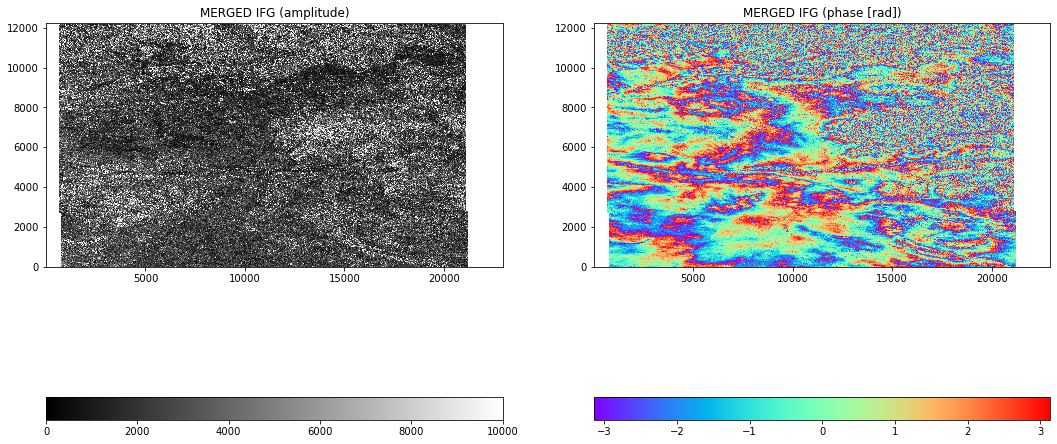

2022-08-26 22:13:18,694 - matplotlib.colorbar - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fbd73d64908>
2022-08-26 22:13:18,695 - matplotlib.colorbar - DEBUG - Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fbd73d64908> on colorbar
2022-08-26 22:13:18,696 - matplotlib.colorbar - DEBUG - Setting pcolormesh
2022-08-26 22:13:20,168 - matplotlib.colorbar - DEBUG - locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fbd73d58f60>
2022-08-26 22:13:20,170 - matplotlib.colorbar - DEBUG - Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7fbd73d58f60> on colorbar
2022-08-26 22:13:20,170 - matplotlib.colorbar - DEBUG - Setting pcolormesh


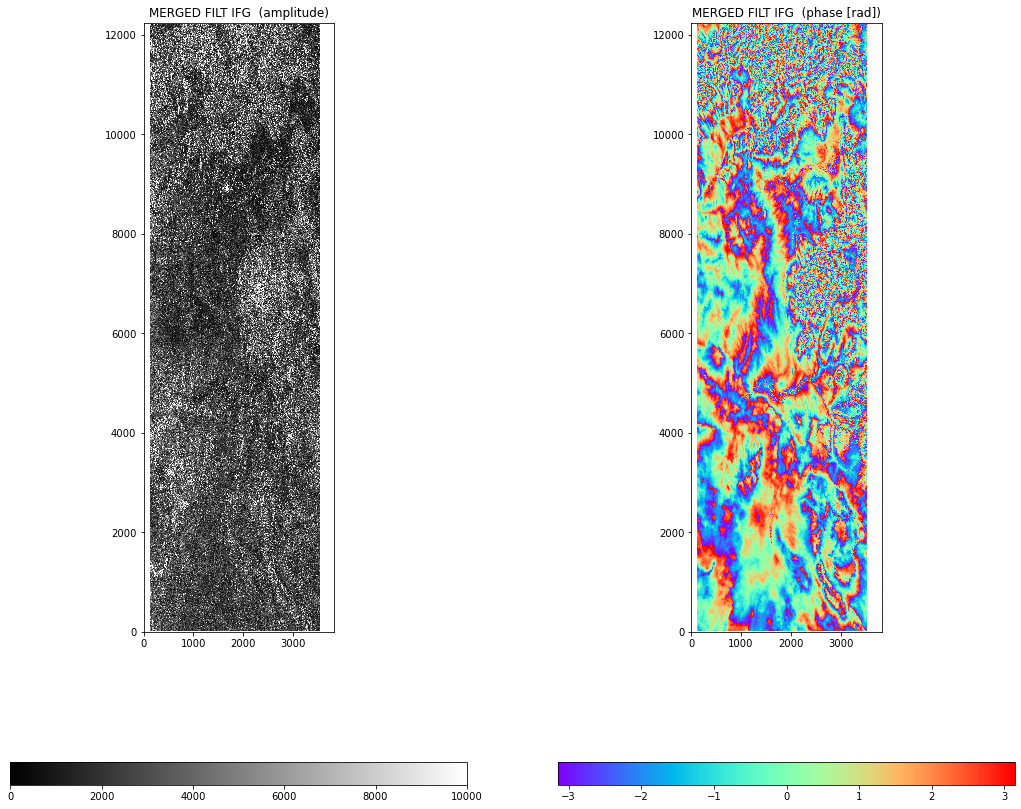

In [23]:
# Plot wrapped interferograms
plotcomplexdata('/tmp/merged/topophase.flat.vrt', 
                title="MERGED IFG",
                datamin=0, datamax=10000, draw_colorbar=True)
plotcomplexdata('/tmp/merged/filt_topophase.flat.vrt', 
                title="MERGED FILT IFG ",
                datamin=0, datamax=10000, draw_colorbar=True)

In [ ]:
# Plot unwrapped interferograms
plotdata('/tmp/merged/filt_topophase.unw.vrt', 
                title="unwrapped phase",
                datamin=0, datamax=10000, draw_colorbar=True)
plotdata('/tmp/merged/filt_topophase.unw.conncomp.vrt', 
                title="connected components",
                datamin=0, datamax=10000, draw_colorbar=True)

In [ ]:
!topsApp.py --dostep=geocode

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2022-08-26 22:17:42,228 - isce.insar - INFO - ISCE VERSION = 2.5.1, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20210305, CURRENT_SVN_REVISION = 
ISCE VERSION = 2.5.1, RELEASE_SVN_REVISION = ,RELEASE_DATE = 20210305, CURRENT_SVN_REVISION = 
Step processing
Running step geocode
2022-08-26 22:17:42,288 - isce.topsinsar.runGeocode - INFO - Geocoding Image
Number of products to geocode:  6
Writing geotrans to VRT for usgs_1m.dem.wgs84
Output:  merged/phsig.cor.geo
API open (WR): merged/dem.crop
API open (WR): merged/phsig.cor.geo
GDAL open (R): merged/phsig.cor.vrt
GDAL open (R): u

# plot unwrapped, geocoded interferograms and coherence
plotdata('/tmp/merged/filt_topophase.unw.vrt', band=2,
         title="UNW FILT IFG [rad]", colormap='jet',
         colorbar_orientation="vertical", datamin=-20, datamax=50)

plotdata('/tmp/merged/filt_topophase.unw.conncomp.vrt', band=1,
         title="UNW FILT IFG connected components",
         colorbar_orientation="vertical")

plotdata('/tmp/merged/filt_topophase.unw.conncomp.vrt', band=1,
         title="UNW FILT IFG Coherence",
         colorbar_orientation="vertical")